In [1]:
from tkinter import *
from tkinter.tix import *
import tkinter.messagebox
import math
import time
from typing import Optional
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import scipy.optimize as opt
from Elements import Cell, Pedestrian, Obstacle, Target
from Model import Model

The following function is used to display the grid in the given Tkinter canvas window

In [2]:
def display(simulation: Model):
    """
    This function creates a given Model in the canvas
    :param simulation: Model to be displayed
    :return: None
    """
    # defining start cooridnates
    x0=50
    y0=25
    # Mapping colors to underlying chars in grid
    color_dict = {"P": "red", "O": "purple", "T":"goldenrod", " ": "white"}
    for i in range(simulation.grid_height):
        for j in range(simulation.grid_width):
            # calculating the koordinates for every cell
            top_x = x0+simulation.grid_unit*j
            top_y = y0+simulation.grid_unit*i
            low_x = top_x+simulation.grid_unit
            low_y = top_y+simulation.grid_unit
            # creating the cell in the respective color and with its char
            canvas.create_rectangle(top_x, top_y, low_x, low_y, fill=color_dict.get(simulation.grid[i][j][0]),outline="black")
            canvas.create_text((top_x+low_x)/2, (top_y+low_y)/2, text = simulation.grid[i][j], font=('Pursia',int(simulation.grid_unit/2)))
            


# GUI VISUALIZATION

The following cell contains all functions used within the GUI visualization

In [3]:
# creating a Tkinter-Canvas
root = tkinter.Tk()
root.title("Cellular Automaton")
root.resizable(width=True,height=True)
canvas = tkinter.Canvas(root, width=400, height=400)

# Initializing an empty model grid
simulation = Model(grid_width=10, grid_height=10, targets=[], obstacles=[], pedestrians=[])
display(simulation)

canvas.pack(fill="both", expand=True)
    
def next_step():
    """
    This function is executing the next stepp
    :return: None
    """
    canvas.delete("all")
    simulation.simulate_one_step()
    display(simulation)

def run_to_finish():
    """
    This function runs the simulation till all pedestrians reached the target
    :return: None
    """
    canvas.delete("all")
    while not simulation.all_finished():
        next_step()
        canvas.update()
    # last step necessary so that pedestrians disappear in target 
    next_step()
    # displaying pedestrians speed 
    for p in simulation.pedestrians:
        label = Label(root, bg='green', padx=3, pady=3, anchor=NW,
                          text=f"Pedestrian {p.name} finished after "
                               f"{p.moved_cells*p.body_dimension/p.actual_speed} seconds")
        label.pack()
        
def empty_cell():
    """
    This function removes either a pedestrian, obstacle or a target from the grid
    :return: None
    """
    cell_to_delete = Cell(rowNum.get()-1,colNum.get()-1)
    for cell in simulation.pedestrians + simulation.obstacles + simulation.targets:
        if cell.isEqual(cell_to_delete):
            del cell
            break
    simulation.grid[cell_to_delete.x][cell_to_delete.y] = simulation.empty
    display(simulation)

def add_pedestrian(update_display: bool = True, x: Optional[int]=None, y: Optional[int]=None):
    """
    This function adds a pedestrian in the desired coordinates

    :param update_display: updating displayed grid after each added Pedestrian,
        False in case of adding multiple pedestrians because of speed reasons
    :param x: x Coordinate
    :param y: y Coordinate
    :return: None
    """
    # if Coordinates are not defined, take Coordinates from input
    if x is None:
        x = rowNum.get()-1
    if y is None:
        y = colNum.get()-1
    # adding pedestrian number to new pedestrian
    ped_number = len(simulation.pedestrians)
    cell_to_add = Pedestrian(x, y, name=str(ped_number))
    simulation.pedestrians.append(cell_to_add)
    simulation.grid[cell_to_add.x][cell_to_add.y] = cell_to_add.name
    if update_display:
        display(simulation)

def randomly_distribute(pedestrians: int, specified_area: tuple):
    """
    This function randomly distributes pedestrians in a specified area

    :param pedestrians: Amount of pedestrians to add
    :param specified_area: area the pedestrians should be created in
    :return: None
    """
    # creating a list with all empty cells
    coord_list = []
    for i in range(specified_area[1], specified_area[3]):
        for j in range(specified_area[0], specified_area[2]):
            if simulation.grid[i][j] == ' ':
                coord_list.append((i, j))

    # randomly distributing the pedestrians in the free cells
    for person in range(pedestrians+1):
        random_coord = random.choice(coord_list)
        add_pedestrian(update_display=False, x=random_coord[0], y=random_coord[1])
        coord_list.remove(random_coord)

def get_truncated_normal(mean, sd, low, upp) -> float:
    """
    Function to normal distribute the speeds within the given ranges

    :param mean: mean value
    :param sd: standard deviation
    :param low: lower bound of speed
    :param upp: upper bound of speed
    :return: randomly chosen value normal distributed between bounds
    """
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        
def define_age_and_speed():
    """
    This function adds a randomly chosen age and a speed in accordance to its age to the pedestrian

    :return: None
    """
    for ped in simulation.pedestrians:
        ped.age = random.randint(20, 80)
        if ped.age < 30:
            low=0.58
            upp=1.61
        elif 30 < ped.age < 50:
            low=1.41
            upp=1.54
        else:
            low=0.68
            upp=1.41      
        ped.speed_meter_per_sec = get_truncated_normal(mean=(low+upp)/2, sd=.2, low=low, upp=upp).rvs()
        
    
def add_density(density: float, specified_area: tuple):
    """
    This function adds a pedestrian density to a specified area

    :param density: desired density in pedestrians per meter
    :param specified_area: area with format (width0, height0, width1, height1)
    :return: None
    """
    width = specified_area[2] - specified_area[0]
    height = specified_area[3] - specified_area[1]
    # calculating the amount of pedestrians to be added in given area
    empty_space_units = width *  height - len(simulation.obstacles) - len(simulation.targets)
    area_per_person = simulation.body_dimension**2
    empty_space_in_m = empty_space_units*area_per_person
    pedestrians_to_add = int(empty_space_in_m * density) - len(simulation.pedestrians)
    # randomly distributing the pedestrians in area
    randomly_distribute(pedestrians_to_add, specified_area)
    display(simulation)

def add_obstacle(update_display: bool=True, x: Optional[int]=None, y: Optional[int]=None):
    """
    This function adds an obstacle to the grid 
    :param update_display: updating displayed grid after each added obstacle,
        False in case of adding multiple obstacle because of speed reasons
    :param x: x Coordinate
    :param y: y Coordinate
    :return: None
    """
    # if no coordinates given, take coordinates from entry field 
    if x is None:
        x=rowNum.get()-1
    if y is None:
        y=colNum.get()-1
    cell_to_add = Obstacle(x, y)
    simulation.obstacles.append(cell_to_add)
    simulation.grid[cell_to_add.x][cell_to_add.y] = cell_to_add.name
    if update_display:
        display(simulation)
    
def add_big_obstacle(specified_area: tuple):
    """
    This function adds a big obstacle in the given area
    :param specified_area: area with format (width0, height0, width1, height1)
    :return: None
    """
    for i in range(specified_area[1], specified_area[3]):
        for j in range(specified_area[0], specified_area[2]):
            add_obstacle(update_display=False, x=i, y=j)
    display(simulation)

def add_target():
    """
    This function adds a target to the given grid 
    :return: None
    """
    # extract coordinates from entry field
    cell_to_add = Target(rowNum.get()-1,colNum.get()-1)
    simulation.targets.append(cell_to_add)
    simulation.grid[cell_to_add.x][cell_to_add.y] = cell_to_add.name
    display(simulation)
    
def task_1():
    """
    Task 1 of the exercise sheet
    :return: None
    """
    canvas.delete("all")
    start_cell = Pedestrian(0, 0)
    target_cell = Target(3, 2)
    global simulation
    simulation = Model(grid_unit = 16, grid_width=5, grid_height=5, pedestrians=[start_cell], targets=[target_cell], obstacles=[])
    display(simulation)
    
def task_2():
    """
    Task 2 of the exercise sheet
    :return: None
    """
    canvas.delete("all")
    start_cell = Pedestrian(4,24)
    target_cell = Target(24, 24)
    global simulation
    simulation = Model(grid_unit = 8, grid_width=50, grid_height=50, pedestrians=[start_cell], targets=[target_cell], obstacles=[], disappear=False)
    display(simulation)

def task_3():
    """
    Task 3 of the exercise sheet
    :return: None
    """
    canvas.delete("all")
    start_cells = [Pedestrian(0,6),Pedestrian(0,42),Pedestrian(6,0),Pedestrian(48,6),Pedestrian(48,42)]
    target_cell = Target(24, 24)
    global simulation
    simulation = Model(grid_unit = 8, grid_width=50, grid_height=50, pedestrians=start_cells, targets=[target_cell], obstacles=[])
    display(simulation)
    
def scenario_one():
    """
    Task 5: Rimea scenario 1 
    :return: None
    """
    canvas.delete("all")
    start_cell = Pedestrian(0, 0)
    global simulation
    # converting from cells to meter with predefined 3 cells are equal to 1 meter 
    conversion_factor = int(1/simulation.body_dimension)
    target_cell = Target(0*conversion_factor, 4*conversion_factor-1)
    simulation = Model(grid_width=4, grid_height=2, pedestrians=[start_cell], targets=[target_cell], obstacles=[], in_meter=True)
    display(simulation)


def scenario_four():
    """
    Task 5: Rimea scenario 4 
    :return: None
    """
    canvas.delete("all")
    global simulation
    # converting from cells to meter with predefined 3 cells are equal to 1 meter 
    conversion_factor = int(1/simulation.body_dimension)
    target_cell = Target(5*conversion_factor, 70*conversion_factor-1)
    simulation = Model(grid_unit=3, grid_width=100, grid_height=10, targets=[target_cell], obstacles=[], pedestrians=[], in_meter=True)
    add_density(density=6.0, specified_area=(30*conversion_factor, 0*conversion_factor,
                                            40*conversion_factor, 10*conversion_factor))
    display(simulation)
    
def scenario_six():
    """
    Task 5: Rimea scenario 6 
    :return: None
    """
    canvas.delete("all")
    global simulation
    # converting from cells to meter with predefined 3 cells are equal to 1 meter 
    conversion_factor = int(1/simulation.body_dimension)
    target_cell = Target(0*conversion_factor, 12*conversion_factor-1)
    simulation = Model(grid_width=12, grid_height=12, targets=[target_cell], obstacles=[], pedestrians=[], in_meter=True)
    add_density(density=20/12.0,
               specified_area=(0*conversion_factor, 10*conversion_factor, 
                               6*conversion_factor, 12*conversion_factor))
    add_big_obstacle(specified_area=(0*conversion_factor, 0*conversion_factor, 
                                     10*conversion_factor, 10*conversion_factor))

    display(simulation)      

def scenario_seven():
    """
    Task 5: Rimea scenario 7 
    :return: None
    """
    canvas.delete("all")
    global simulation
    # converting from cells to meter with predefined 3 cells are equal to 1 meter 
    conversion_factor = int(1/simulation.body_dimension)
    target_cell = Target(8*conversion_factor, 16*conversion_factor-1)
    simulation = Model(grid_width=16, grid_height=16, targets=[target_cell], obstacles=[], pedestrians=[], in_meter=True)
    add_density(density=50/16.0, specified_area=(0*conversion_factor, 0*conversion_factor,
                                                1*conversion_factor, 16*conversion_factor))
    define_age_and_speed()
    display(simulation)

   
    
    
clickButton = Button(root, text = "NEXT STEP", command = next_step).pack()
runSimulation = Button(root, text = "RUN SIMULATION", command = run_to_finish).pack()

rowNum = tkinter.IntVar()
rowLabel = Label(root, text = f'Row Number [1-10]').pack()
rowEntry = Entry(root,textvariable = rowNum).pack()

colNum = tkinter.IntVar()
colLabel = Label(root, text = f'Column Number [1-10]').pack()
colEntry=Entry(root, textvariable = colNum).pack()

add_Pedestrian = Button(root, text = "Add Pedestrian", command = add_pedestrian).pack()
add_Obstacle = Button(root, text = "Add Obstacle", command = add_obstacle).pack()
add_Target = Button(root, text = "Add Target", command = add_target).pack()
empty_Cell = Button(root, text = "Delete Cell", command = empty_cell).pack()

task_1 = Button(root, text = "Task 1", command = task_1).pack(side=LEFT)
task_2 = Button(root, text = "Task 2", command = task_2).pack(side=LEFT)
task_3 = Button(root, text = "Task 3", command = task_3).pack(side=LEFT)

scenario1 = Button(root, text = "RiMEA Scenario 1", command = scenario_one).pack(side=LEFT)
scenario4 = Button(root, text = "RiMEA Scenario 4", command = scenario_four).pack(side=LEFT)
scenario6 = Button(root, text = "RiMEA Scenario 6", command = scenario_six).pack(side=LEFT)
scenario7 = Button(root, text = "RiMEA Scenario 7", command = scenario_seven).pack(side=LEFT)

root.mainloop()

KeyboardInterrupt: 

# The following Cell is used to plot the age against the speed

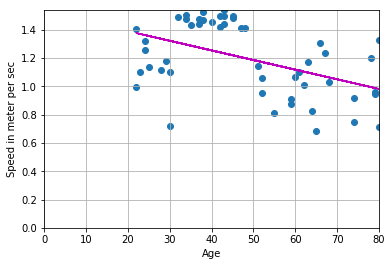

In [9]:
x = []
y = []
for p in simulation.pedestrians:
    x.append(p.age)
    y.append(p.speed_meter_per_sec)
plt.scatter(x=np.array(x), y=np.array(y))
plt.ylim([0, np.array(y).max()])
plt.xlim([0, np.array(x).max()])

pfit = np.polyfit(x, y, 1)
trend_line_model = np.poly1d(pfit)

plt.plot(x, trend_line_model(x), "m--")
plt.xlabel("Age")
plt.ylabel("Speed in meter per sec")
plt.grid()
# plt.savefig('speed_age_scenario7.png')
plt.show()

In [7]:
 plt.show()


In [ ]:
np.mean(y)